# UniNa - Machine Learning 22/23 - MiniContest n1
---

### Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("Train.csv")

In [3]:
df.head()

,ID,B12,B07,B06,B04,B03,B11,B8A,B02,B05,B08,Class
0,1,0.0903,0.4145,0.3290,0.0404,0.0580,0.1975,0.4480,0.0281,0.0945,0.4236,High
1,2,0.1108,0.4818,0.3650,0.0501,0.0624,0.2326,0.5060,0.0379,0.0959,0.5192,High
2,3,0.0896,0.4016,0.3082,0.0387,0.0515,0.1915,0.4217,0.0304,0.0872,0.3974,High
3,4,0.0803,0.3781,0.2893,0.0375,0.0499,0.1756,0.4025,0.0239,0.0764,0.3937,High
4,5,0.0900,0.3842,0.3060,0.0378,0.0510,0.1960,0.4217,0.0261,0.0903,0.3858,High


In [4]:
dataset = df.sample(frac=1)

In [5]:
target = dataset['Class']

In [6]:
data = dataset.drop('ID', axis=1).drop('Class', axis=1)

In [10]:
X = data.to_numpy()
y = target.to_numpy()

In [ ]:
df.info()

In [ ]:
df.describe().T

In [ ]:
df.isnull().sum()

In [7]:
target.value_counts()

Medium       31326
Absent       30615
High         30294
Low          27452
Very High    18689
Name: Class, dtype: int64

### Exploratory Data Analysis

In [8]:
sns.set_style('whitegrid')
sns.pairplot(df, hue='Class', palette='coolwarm')

In [9]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

Two features being highly correlated with each other will provide too much and useless information on finding the target (eg. B8A and B07).

The dataset is clean, there are not missing values (NaNs) so we can start with scaling, Train-Test-Split and applying the algorithms.

### Scaling data

In [11]:
from sklearn.preprocessing import RobustScaler

In [12]:
scaler = RobustScaler()

In [13]:
scaler.fit(X)

RobustScaler()

In [14]:
scaled_features = scaler.fit_transform(X)

In [20]:
df_feat = pd.DataFrame(scaled_features, columns=df.columns[1:-1])
df_feat.head()

,B12,B07,B06,B04,B03,B11,B8A,B02,B05,B08
0,0.634831,0.970768,1.082692,0.494444,0.969849,0.610028,1.021291,0.198413,0.819355,0.894911
1,0.612360,0.310673,0.588462,1.372222,1.271357,0.299443,0.363273,0.841270,1.045161,0.513549
2,-0.367978,0.210741,0.126923,0.238889,-0.080402,-0.310585,0.206254,-0.174603,-0.419355,0.151355
3,-0.176966,0.460911,0.353846,-0.477778,-0.386935,0.087744,0.550233,-0.769841,-0.187097,0.298083
4,-1.022472,-0.947655,-1.011538,-0.311111,-0.869347,-1.235376,-0.981371,-0.793651,-0.700000,-0.900859


### Train test split

In [26]:
X = df_feat.to_numpy()

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100, stratify=y, shuffle=True)

## Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
dtree = DecisionTreeClassifier(random_state=42)

In [33]:
parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [2, 3, 5, 10, 20, 25, 30],
    'min_samples_leaf': [5, 10, 20, 50, 75, 100],
}

In [34]:
grid_search = GridSearchCV(estimator=dtree,
                           param_grid=parameters,
                           n_jobs=-1,
                           cv=5,
                           scoring = "accuracy")

In [35]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 5, 10, 20, 25, 30],
                         'min_samples_leaf': [5, 10, 20, 50, 75, 100]},
             scoring='accuracy')

In [36]:
print(grid_search.best_params_)
dtree_best = grid_search.best_estimator_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 50}


In [37]:
pred = dtree_best.predict(X_test)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [39]:
print(confusion_matrix(y_test, pred))

[[7894  254  600  342   94]
 [ 173 6749  445 1194  527]
 [ 712  680 4852 1520  472]
 [ 448 1632 1658 4715  945]
 [ 126  402  210  368 4501]]


In [40]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Absent       0.84      0.86      0.85      9184
        High       0.69      0.74      0.72      9088
         Low       0.62      0.59      0.61      8236
      Medium       0.58      0.50      0.54      9398
   Very High       0.69      0.80      0.74      5607

    accuracy                           0.69     41513
   macro avg       0.69      0.70      0.69     41513
weighted avg       0.69      0.69      0.69     41513



In [41]:
print(accuracy_score(y_test, pred))

0.6916146749211091


## k-Nearest Neighbors Classifier

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

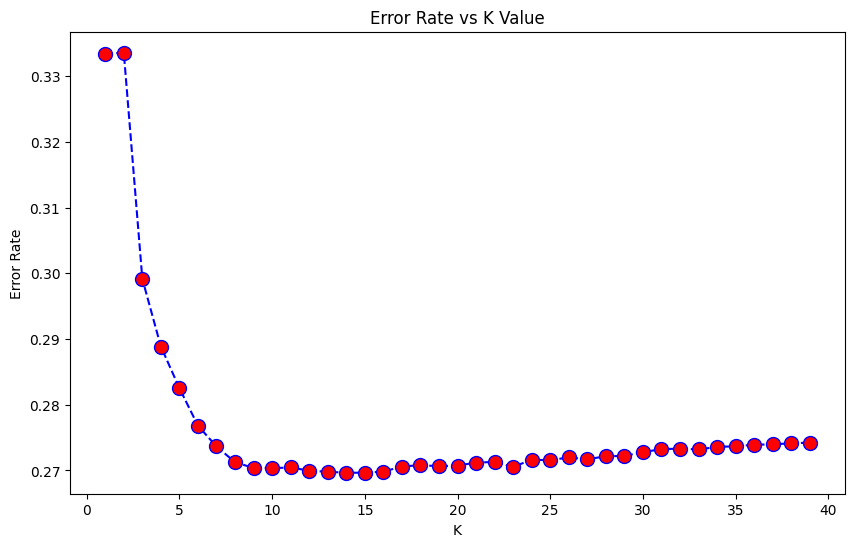

In [44]:
plt.figure(figsize=(10,6))
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

In [45]:
knn = KNeighborsClassifier(n_neighbors=20)

In [46]:
parameters = {
    'leaf_size': (1, 5, 10, 20, 30, 50),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}

In [47]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           n_jobs=-1,
                           cv=5,
                           scoring = "accuracy")

In [48]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=20), n_jobs=-1,
             param_grid={'leaf_size': (1, 5, 10, 20, 30, 50),
                         'metric': ('minkowski', 'chebyshev'), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy')

In [49]:
print(grid_search.best_params_)
knn_best = grid_search.best_estimator_

{'leaf_size': 1, 'metric': 'minkowski', 'p': 2, 'weights': 'distance'}


In [50]:
pred = knn_best.predict(X_test)

In [51]:
print(confusion_matrix(y_test, pred))

[[8190  211  418  294   71]
 [ 114 7215  282  989  488]
 [ 566  628 5070 1419  553]
 [ 279 1514 1484 5182  939]
 [  84  483   96  239 4705]]


In [52]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Absent       0.89      0.89      0.89      9184
        High       0.72      0.79      0.75      9088
         Low       0.69      0.62      0.65      8236
      Medium       0.64      0.55      0.59      9398
   Very High       0.70      0.84      0.76      5607

    accuracy                           0.73     41513
   macro avg       0.73      0.74      0.73     41513
weighted avg       0.73      0.73      0.73     41513



In [53]:
print(accuracy_score(y_test, pred))

0.7313853491677306


## SVM

In [54]:
from sklearn.svm import SVC

In [55]:
svc = SVC()

In [56]:
parameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01],
}

In [57]:
grid_search = GridSearchCV(estimator=svc,
                           param_grid=parameters,
                           n_jobs=-1,
                           cv=5,
                           scoring = "accuracy")

In [58]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01]},
             scoring='accuracy')

In [59]:
print(grid_search.best_params_)
svc_best = grid_search.best_estimator_

{'C': 10, 'gamma': 1}


In [60]:
pred = svc_best.predict(X_test)

In [61]:
print(confusion_matrix(y_test, pred))

[[8428  117  418  204   17]
 [ 212 7271  248  892  465]
 [ 594  492 5397 1284  469]
 [ 346 1305 1349 5532  866]
 [ 188  272   85  141 4921]]


In [62]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Absent       0.86      0.92      0.89      9184
        High       0.77      0.80      0.78      9088
         Low       0.72      0.66      0.69      8236
      Medium       0.69      0.59      0.63      9398
   Very High       0.73      0.88      0.80      5607

    accuracy                           0.76     41513
   macro avg       0.75      0.77      0.76     41513
weighted avg       0.76      0.76      0.76     41513



In [63]:
print(accuracy_score(y_test, pred))

0.7599788018211163


## Multi-layer Perceptron Classifier

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
mlp = MLPClassifier(max_iter=1000)

In [66]:
parameters = {
    "activation" : ("identity", "logistic", "tanh", "relu"),
    "solver" : ("lbfgs", "sgd", "adam"),
    "alpha": [0.0001, 0.01],
    "hidden_layer_sizes" : ((50,50,50), (100,))
}

In [67]:
grid_search = GridSearchCV(estimator=mlp,
                           param_grid=parameters,
                           n_jobs=-1,
                           cv=5,
                           scoring = "accuracy")

In [68]:
grid_search.fit(X_train, y_train)

/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/ne

/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/ne

/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/ne

/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/szymon/Studia_AGH/Semestr_5/ML/Mini_contest/venv/lib/python3.10/site-packages/sklearn/ne

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'activation': ('identity', 'logistic', 'tanh', 'relu'),
                         'alpha': [0.0001, 0.01],
                         'hidden_layer_sizes': ((50, 50, 50), (100,)),
                         'solver': ('lbfgs', 'sgd', 'adam')},
             scoring='accuracy')

In [69]:
print(grid_search.best_params_)
mlp_best = grid_search.best_estimator_

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'}


In [70]:
pred = mlp_best.predict(X_test)

In [71]:
print(confusion_matrix(y_test, pred))

[[8468  102  370  224   20]
 [  89 7364  269  850  516]
 [ 594  449 5424 1309  460]
 [ 258 1303 1408 5566  863]
 [  46  274  109  204 4974]]


In [72]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Absent       0.90      0.92      0.91      9184
        High       0.78      0.81      0.79      9088
         Low       0.72      0.66      0.69      8236
      Medium       0.68      0.59      0.63      9398
   Very High       0.73      0.89      0.80      5607

    accuracy                           0.77     41513
   macro avg       0.76      0.77      0.76     41513
weighted avg       0.76      0.77      0.76     41513



In [73]:
print(accuracy_score(y_test, pred))

0.7659287452123431


## Evaluating choosen model on a test data

In [103]:
test_df = pd.read_csv("Test.csv")

In [104]:
test_df.isnull().sum()

ID     0
B12    0
B07    0
B06    0
B04    0
B03    0
B11    0
B8A    0
B02    0
B05    0
B08    0
dtype: int64

In [105]:
test_df_no_ID = test_df.drop("ID", axis=1)

In [106]:
test_set = test_df_no_ID.to_numpy()

In [107]:
scaler.fit(test_set)

RobustScaler()

In [108]:
scaled_test_features = scaler.fit_transform(test_set)

In [109]:
scaled_test_set = pd.DataFrame(scaled_test_features, columns = test_df.columns[1:])
scaled_test_set.head()

,B12,B07,B06,B04,B03,B11,B8A,B02,B05,B08
0,-0.931624,-0.443843,-0.466094,-0.480226,-0.761421,-1.034819,-0.430371,-0.722222,-0.665574,-0.592763
1,0.735043,-0.307172,-0.181471,1.180791,0.477157,0.566852,-0.218170,0.365079,1.304918,-0.426974
2,-0.017094,0.582544,0.590258,-0.418079,-0.304569,0.168524,0.731432,-0.555556,-0.150820,0.696711
3,-0.333333,0.181326,0.178606,-0.796610,-0.553299,-0.192201,0.207560,-0.587302,-0.495082,0.278947
4,-1.091168,-0.665088,-0.654250,-0.683616,-0.786802,-1.278552,-0.700928,-0.785714,-0.639344,-0.607237


In [110]:
scaled_test_set = scaled_test_set.to_numpy()

### Decision Tree Classifier predictions

In [111]:
test_pred_dtree = dtree_best.predict(scaled_test_set)

In [112]:
final_pred_dtree = pd.DataFrame(data={"ID": test_df["ID"],
                                      "Class": pd.Series(test_pred_dtree)})
final_pred_dtree.to_csv("mini_contest_1_results_dtree.csv", index=False)

### k-Nearest Neighbors Classifier

In [113]:
test_pred_knn = knn_best.predict(scaled_test_set)

In [114]:
final_pred_knn = pd.DataFrame(data={"ID": test_df["ID"],
                                    "Class": pd.Series(test_pred_knn)})
final_pred_knn.to_csv("mini_contest_1_results_knn.csv", index=False)

### SVM

In [115]:
test_pred_svm = svc_best.predict(scaled_test_set)

In [116]:
final_pred_svm = pd.DataFrame(data={"ID": test_df["ID"],
                                    "Class": pd.Series(test_pred_svm)})
final_pred_svm.to_csv("mini_contest_1_results_svm.csv", index=False)

### Multi-layer Perceptron Classifier

In [117]:
test_pred_mlp = mlp_best.predict(scaled_test_set)

In [118]:
final_pred_mlp = pd.DataFrame(data={"ID": test_df["ID"],
                                    "Class": pd.Series(test_pred_mlp)})
final_pred_mlp.to_csv("mini_contest_1_results_mlp.csv", index=False)